# Line-lenght detection
## Loading signal
### Importing data

In [18]:
from pyhfo_detect.io import data_feeder, add_metadata
from pyhfo_detect.io.data_operations import create_output_df
from pyhfo_detect.core import ll_detect
from scipy.signal import butter, filtfilt
from pyhfo_detect.thresholds import *
from pyhfo_detect.signal_transform import *
from pyhfo_detect.feature_extraction import *

import os
import pyhfo_detect
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

### Founding path to signal

In [19]:
file_path = '/mnt/BME_shared/raw_data/SEEG/seeg-032-141008/Easrec_ic_exp-032_141008-0929.d'

### Getting data

In [20]:
data,fs = data_feeder(file_path, 0, 50000, "B'1")

#### Plotting data

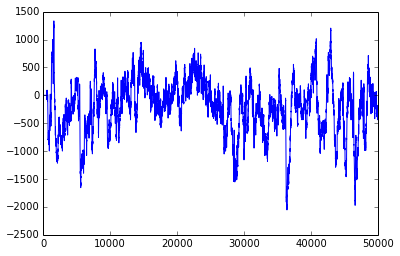

In [21]:
plt.plot(data)

### Metadata

In [22]:
met_dat = {'channel_name':"B'1", 'pat_id':'12'}

### Line-lenght detection

In [23]:
LL_df = ll_detect(data, fs, 80, 600, 1, 0.1, 0.25)
# def ll_detect(data, fs, low_fc, high_fc,threshold, window_size, window_overlap): 
# returns df_out

#### Start of function line-lenght
##### Line-length detection algorithm and its variants.
Line-length detection algorithm. (CITATIONS)
    

Parameters:
<ul>    
<li>data(1-d numpy array) - raw data</li>
<li>fs(int) - sampling frequency</li>
<li>low_fc(float) - low cut-off frequency</li>
<li>high_fc(float) - high cut-off frequency</li>
<li>window_size(float) - sliding window size in secs</li>
<li>window_overlap(float) - fraction of the window overlap (0 to 1)</li>
</ul>    

Returns:
<ul>
<li>df_out(pandas.DataFrame) - output dataframe with detections</li>
</ul>

##### Definition of variables

In [24]:
low_fc = 80
high_fc = 600
threshold = 1
window_size = 0.1
window_overlap = 0.25

##### Calculating window values

In [25]:
samp_win_size = int(window_size*fs) # Window size in samples
samp_win_inc = int(samp_win_size*window_overlap) # Window increment in samples

##### Creating output dataframe

In [26]:
df_out = create_output_df()

##### Filtering data

In [27]:
b, a = butter (3,[low_fc/(fs/2), high_fc/(fs/2)], 'bandpass')
filt_data = filtfilt(b, a, data)    

###### Plotting filtred data

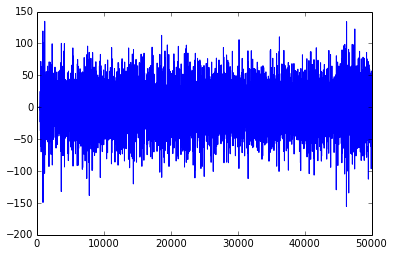

In [28]:
plt.plot(filt_data)

##### Overlapping window

In [29]:
win_start = 0
win_stop = window_size*fs
LL = []
while win_start < len(filt_data):
    if win_stop > len(filt_data):
        win_stop = len(filt_data)
            
    
    LL.append(extract_line_lenght(filt_data[int(win_start):int(win_stop)]))
        
    win_start += samp_win_inc
    win_stop += samp_win_inc
    

##### Creating treshold

In [32]:
det_th = th_std(LL,threshold)

##### Detection

In [33]:
LL_idx=0
df_idx=0
while LL_idx < len(LL):
    if LL[LL_idx] >= det_th:
        event_start = LL_idx * samp_win_inc
        while LL_idx < len(LL) and LL[LL_idx] >= det_th:
                LL_idx += 1
        event_stop = (LL_idx * samp_win_inc)+samp_win_size
           
        if event_stop > len(data):
            event_stop = len(data)
        
        # Optional feature calculations can go here

        # Write into dataframe
        df_out.loc[df_idx] = [event_start, event_stop]
        df_idx += 1

        LL_idx += 1
    else:
        LL_idx += 1
    
# return df_out

#### End of function line-lenght
#### Adding metadata

In [34]:
LL_df = add_metadata(LL_df,met_dat)

#### Optional rearaging of columns

In [35]:
LL_df = LL_df.loc[:,['pat_id','channel_name','event_start','event_stop']]

#### Plotting the detections in signal

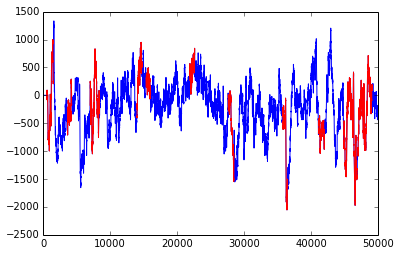

In [36]:
plt.plot(data)
for row in LL_df.iterrows():
    det_size = row[1].event_stop-row[1].event_start
    plt.plot(np.linspace(row[1].event_start,row[1].event_stop,det_size,endpoint=False),
             data[row[1].event_start:row[1].event_stop],'r-')